In [1]:
# Experiment 2 Script for COVID-19 Forecasting
# Change path to the root directory of the project
import os
os.chdir("../../")

# Description: This script contains the code for the second experiment in the project, 
# forecasting COVID-19 MVBeds using various RNN models and hyperparameter tuning with Simulated Annealing.

# Imports for handling data
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import cycle

# Imports for machine learning
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, mean_absolute_percentage_error as mape

# Imports for visualization
import plotly.express as px
import plotly.graph_objects as go

# Progress bar
from tqdm.autonotebook import tqdm
tqdm.pandas()

# Local imports for data loaders and models
# from src.utils import plotting_utils
# from src.dl.dataloaders import TimeSeriesDataModule
# from src.dl.multivariate_models import SingleStepRNNConfig, SingleStepRNNModel, Seq2SeqConfig, Seq2SeqModel, RNNConfig
# from src.transforms.target_transformations import AutoStationaryTransformer

# Set seeds for reproducibility
pl.seed_everything(42)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

torch.set_float32_matmul_precision('high')

# Set default plotly template
import plotly.io as pio
pio.templates.default = "plotly_white"

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import logging

# Set logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


Seed set to 42


In [2]:
# Utility Functions

def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig

def mase(actual, predicted, insample_actual):
    mae_insample = np.mean(np.abs(np.diff(insample_actual)))
    mae_outsample = np.mean(np.abs(actual - predicted))
    return mae_outsample / mae_insample

def forecast_bias(actual, predicted):
    return np.mean(predicted - actual)

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def plot_forecast(pred_df, forecast_columns, selected_area, forecast_display_names=None, save_path=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = px.colors.qualitative.D3  # Use a colorblind-friendly palette
    act_color = colors[0]
    colors = cycle(colors[1:])

    fig = go.Figure()

    # Actual data plot
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].covidOccupiedMVBeds,
            mode="lines+markers",
            marker=dict(size=8, opacity=0.7, symbol='circle'),
            line=dict(color=act_color, width=3),
            name="Actual COVID-19 MVBeds trends",
        )
    )

    # Predicted data plot
    line_styles = ["solid", "dash", "dot", "dashdot"]
    markers = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up']
    for col, display_col, line_style, marker in zip(forecast_columns, forecast_display_names, cycle(line_styles), cycle(markers)):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines+markers",
                marker=dict(size=6, symbol=marker),
                line=dict(color=next(colors), width=2, dash=line_style),
                name=display_col,
            )
        )

    fig.update_layout(
        title=f"COVID-19 MVBeds Forecast Comparison for {selected_area}",
        title_font=dict(size=20),
        xaxis_title="Date",
        yaxis_title="COVID-19 MVBeds",
        xaxis=dict(title_font=dict(size=15), tickfont=dict(size=12)),
        yaxis=dict(title_font=dict(size=15), tickfont=dict(size=12)),
        legend=dict(
            font=dict(size=10),
            orientation="h",
            yanchor="top",
            y=1.02,  # Move the legend down to separate it from the title
            xanchor="center",
            x=0.5
        ),
        template="plotly_white",
        plot_bgcolor="rgba(0,0,0,0)",
        margin=dict(l=10, r=40, t=80, b=40),  # Adjust left margin for better alignment
        width=1200,
        height=600
    )

    if save_path:
        pio.write_image(fig, save_path)
    return fig


def highlight_abs_min(s, props=""):
    return np.where(s == np.nanmin(np.abs(s.values)), props, "")

# Function to convert data to float32
def to_float32(df):
    for col in df.columns:
        df[col] = df[col].astype("float32")
    return df

In [3]:
# Load and Prepare Data
data_path = Path("data/processed/england_data.csv")
# data = pd.read_csv(data_path).drop("Unnamed: 0", axis=1)
data = pd.read_csv(data_path)
data["date"] = pd.to_datetime(data["date"])

# Select and Process Data
selected_area = "England"
# data_filtered = data[data["areaName"] == selected_area]
data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,openstreetmap_id,latitude,longitude,areaName
0,2020-04-01,0.0,23332,12059.0,3099,3989.0,694.0,35571.0,4730.0,56171302,1275584,474.050001,-12.133333,England
1,2020-04-02,1494.0,26264,12135.0,2932,3895.0,725.0,39466.0,5455.0,56171302,1275584,474.050001,-12.133333,England
2,2020-04-03,1788.0,28828,13635.0,2564,3878.0,737.0,43344.0,6192.0,56171302,1275584,474.050001,-12.133333,England
3,2020-04-04,1950.0,31421,15469.0,2593,3260.0,828.0,46604.0,7020.0,56171302,1275584,474.050001,-12.133333,England
4,2020-04-05,2097.0,34013,16657.0,2592,2994.0,823.0,49598.0,7843.0,56171302,1275584,474.050001,-12.133333,England


In [4]:
# Add time-lagged features
def add_lags(data, lags, features):
    added_features = []
    for feature in features:
        for lag in lags:
            new_feature = feature + f"_lag_{lag}"
            data[new_feature] = data[feature].shift(lag)
            added_features.append(new_feature)
    return data, added_features


lags = [1, 2, 3, 5, 7, 14, 21]
data, added_features = add_lags(data, lags, ["covidOccupiedMVBeds"])
data.dropna(inplace=True)


# Create temporal features
def create_temporal_features(df, date_column):
    df["month"] = df[date_column].dt.month
    df["day"] = df[date_column].dt.day
    df["day_of_week"] = df[date_column].dt.dayofweek
    return df


data = create_temporal_features(data, "date")
data = data.set_index("date")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 874 entries, 2020-04-22 to 2022-09-12
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   covidOccupiedMVBeds         874 non-null    float64
 1   cumAdmissions               874 non-null    int64  
 2   hospitalCases               874 non-null    float64
 3   newAdmissions               874 non-null    int64  
 4   new_confirmed               874 non-null    float64
 5   new_deceased                874 non-null    float64
 6   cumulative_confirmed        874 non-null    float64
 7   cumulative_deceased         874 non-null    float64
 8   population                  874 non-null    int64  
 9   openstreetmap_id            874 non-null    int64  
 10  latitude                    874 non-null    float64
 11  longitude                   874 non-null    float64
 12  areaName                    874 non-null    object 
 13  covidOccupiedMVB

Epoch 1/100
20/20 - 6s - loss: 1.3973 - mae: 0.8903 - val_loss: 0.0121 - val_mae: 0.1038 - 6s/epoch - 325ms/step
Epoch 2/100
20/20 - 0s - loss: 0.8473 - mae: 0.7041 - val_loss: 0.0378 - val_mae: 0.1910 - 433ms/epoch - 22ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6455 - mae: 0.6055 - val_loss: 0.0140 - val_mae: 0.1127 - 455ms/epoch - 23ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6933 - mae: 0.5898 - val_loss: 0.0118 - val_mae: 0.1027 - 440ms/epoch - 22ms/step
Epoch 5/100
20/20 - 0s - loss: 0.5118 - mae: 0.5399 - val_loss: 0.0155 - val_mae: 0.1196 - 422ms/epoch - 21ms/step
Epoch 6/100
20/20 - 0s - loss: 0.4134 - mae: 0.4809 - val_loss: 0.0127 - val_mae: 0.1074 - 420ms/epoch - 21ms/step
Epoch 7/100
20/20 - 0s - loss: 0.3605 - mae: 0.4583 - val_loss: 0.0060 - val_mae: 0.0695 - 445ms/epoch - 22ms/step
Epoch 8/100
20/20 - 0s - loss: 0.3618 - mae: 0.4370 - val_loss: 0.0091 - val_mae: 0.0894 - 446ms/epoch - 22ms/step
Epoch 9/100
20/20 - 0s - loss: 0.3389 - mae: 0.4204 - val_loss: 0.0067 - val_mae: 

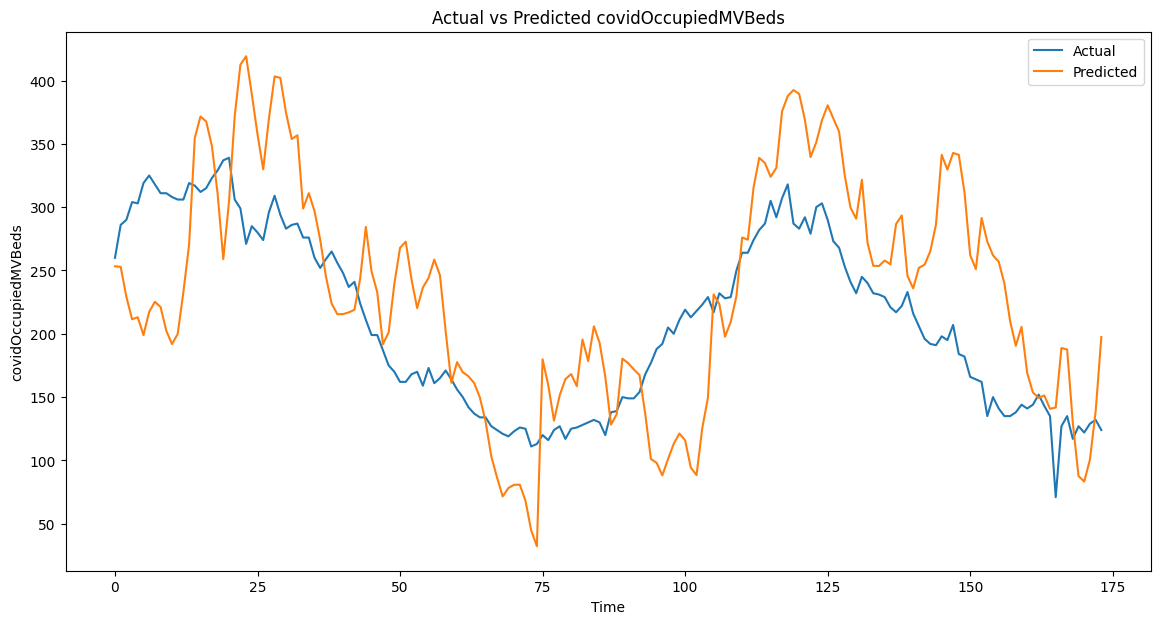

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# Adjust the list of features to exclude the missing columns
adjusted_features = [
    "covidOccupiedMVBeds",
    "covidOccupiedMVBeds_lag_1",
    "covidOccupiedMVBeds_lag_2",
    "covidOccupiedMVBeds_lag_3",
    "covidOccupiedMVBeds_lag_5",
    "covidOccupiedMVBeds_lag_7",
    "covidOccupiedMVBeds_lag_14",
    "covidOccupiedMVBeds_lag_21",
    "month",
    "day",
    "day_of_week",
    # "susceptible",
    # "exposed",
    # "active_cases",
    # "recovered",
    # "cumulative_deceased"
]

# Load the data (assuming the merged_data is already loaded as a DataFrame)
# merged_data = pd.read_csv('data/processed/england_data.csv')

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the data
data_scaled = pd.DataFrame(scaler.fit_transform(data[adjusted_features]), columns=adjusted_features)

# Create windowed sequences for training and testing
def create_windowed_dataset(data, target_column, window_size=7):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size].drop(columns=[target_column]).values)
        y.append(data[target_column].values[i + window_size])
    return np.array(X), np.array(y)

# Prepare the data
target_column = "covidOccupiedMVBeds"
window_size = 7

# Create windowed sequences
X_windowed, y_windowed = create_windowed_dataset(data_scaled, target_column, window_size)

# Split the data into training and testing sets since it is a time series data
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, shuffle=False)

# Reshape the data to fit the RNN input format (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], window_size, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], window_size, X_test.shape[2]))

# Build the enhanced LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2)

# Evaluate the model
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss}, Train MAE: {train_mae}")
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

def rescale_predictions(predictions, X, scaler, original_features):
    # Create a placeholder array for rescaling
    rescaled_predictions = np.zeros((predictions.shape[0], len(original_features)))
    rescaled_predictions[:, 0] = predictions[:, 0]  # Put predictions in the first column
    # Use the remaining columns from the input features to rescale properly
    rescaled_predictions[:, 1:X.shape[2]] = X[:, 0, 1:]
    # Inverse transform using the scaler
    rescaled_predictions = scaler.inverse_transform(rescaled_predictions)
    return rescaled_predictions[:, 0]  # Return only the first column (rescaled predictions)

# Original features used for scaling
original_features = adjusted_features

# # Function to rescale the predicted values
# def rescale_predictions(predictions, X, scaler, original_features):
#     num_features = len(original_features)
#     rescaled_predictions = np.zeros((predictions.shape[0], num_features))
#     rescaled_predictions[:, 0] = predictions[:, 0]
#     rescaled_predictions[:, 1:] = X[:, -1, :-1]
#     rescaled_predictions_full = scaler.inverse_transform(rescaled_predictions)
#     return rescaled_predictions_full[:, 0]

# # Original features used for scaling
# original_features = adjusted_features

# Rescale the predictions and actual values
y_train_pred_rescaled = rescale_predictions(y_train_pred, X_train, scaler, original_features)
y_test_pred_rescaled = rescale_predictions(y_test_pred, X_test, scaler, original_features)
y_train_rescaled = rescale_predictions(y_train.reshape(-1, 1), X_train, scaler, original_features)
y_test_rescaled = rescale_predictions(y_test.reshape(-1, 1), X_test, scaler, original_features)

# Calculate MAE and MSE on the original scale
train_mae_original = mean_absolute_error(y_train_rescaled, y_train_pred_rescaled)
test_mae_original = mean_absolute_error(y_test_rescaled, y_test_pred_rescaled)
train_mse_original = mean_squared_error(y_train_rescaled, y_train_pred_rescaled)
test_mse_original = mean_squared_error(y_test_rescaled, y_test_pred_rescaled)

print(f"Train MAE (original scale): {train_mae_original}")
print(f"Test MAE (original scale): {test_mae_original}")
print(f"Train MSE (original scale): {train_mse_original}")
print(f"Test MSE (original scale): {test_mse_original}")

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_test_pred_rescaled, label='Predicted')
plt.title('Actual vs Predicted covidOccupiedMVBeds')
plt.xlabel('Time')
plt.ylabel('covidOccupiedMVBeds')
plt.legend()
plt.show()
